In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)

W kolumnie administrative_area_level_1 są nazwy krajów jest ich 236

Pozostałe kolumny z grupy Administrative areas mają 100% brakow lub nie jest nam potrzebna,
administrative_area_level przyjmuje jedna wartosc

latitude longitude nie są potrzebne do dalszej analizy

Z grupy danych ISO codes zosatwiamy 1 kolumne iso_alpha_3 mozliwa korzysc przy wizualizacji (brak dla 3 krajów)

Z grupy danych External Keys usuwamy wszystkie klucze nie sa one nam potrzebne do analizy maja duze braki i ciezko je przetworzyc

Zamieniamy format daty na bardziej użyteczny.

Po próbie odzyskania danych z kolumn 'recovered', 'tests', 'vaccines', 'people_vaccinated','people_fully_vaccinated', 'hosp', 'icu', 'vent'
uznaje je za nieistotne z powodu zbyt duzych brakow danych i trudności w ich uzupełnieniu.

Usuwamy dane z brakami ponad 65%


In [ ]:
dane = pd.read_csv("1.csv",low_memory=False)

dane = dane.drop(["administrative_area_level", "administrative_area_level_2", "administrative_area_level_3"], axis=1)
dane = dane.drop(["latitude", "longitude"], axis=1)
dane = dane.drop(["iso_alpha_2", "iso_numeric", "iso_currency"], axis=1)
dane = dane.drop(["key_local", "key_nuts", "key_google_mobility", "key_apple_mobility", "key_jhu_csse", "key_gadm"], axis=1)
dane['date'] = pd.to_datetime(dane['date'], format='%Y-%m-%d')
dane = dane.drop(["id"], axis=1)
brak = dane.isnull().mean()*100
#print(brak)

brak_col = brak[brak<65].index
brak_col2 = brak[brak>65].index

#print(brak_col2)
dane = dane[brak_col]

#print(dane[pd.isna(dane["iso_alpha_3"])]["administrative_area_level_1"].unique())

dane

,date,confirmed,deaths,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,...,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index,administrative_area_level_1,population,iso_alpha_3
0,2020-03-13,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grand Princess,3533.0,NaN
1,2020-03-14,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grand Princess,3533.0,NaN
2,2020-03-15,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grand Princess,3533.0,NaN
3,2020-03-16,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grand Princess,3533.0,NaN
4,2020-03-17,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grand Princess,3533.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286877,2024-05-24,4759647.0,43522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Czech Republic,10629928.0,CZE
286878,2024-05-25,4759648.0,43522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Czech Republic,10629928.0,CZE
286879,2024-05-26,4759649.0,43522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Czech Republic,10629928.0,CZE
286880,2024-05-27,4759670.0,43522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Czech Republic,10629928.0,CZE


Zajmijmy sie danymi komulatywnymi

Z powodu braku zakazeń po 5 maja 2023 usuwamy dalsze dane.

Sprawdzam ilosc danych dla konkretnych krajów.

Usuwam kraje z iloscia danych mniejsza niż półtorej ilości dni przez które były zbierane.

Z powodu dużego braku dannych w raportowaniu krajów od stycznie 2023 usuwamy dalsze dane.

Braki w kolumnie zakarzeń:
Oficjalny koniec pandemii:2023-05-05 
Wszystkie dane: 16.52%
Przed 5.05.2023: 9.94%
Po 5.05.2023: 58.31%



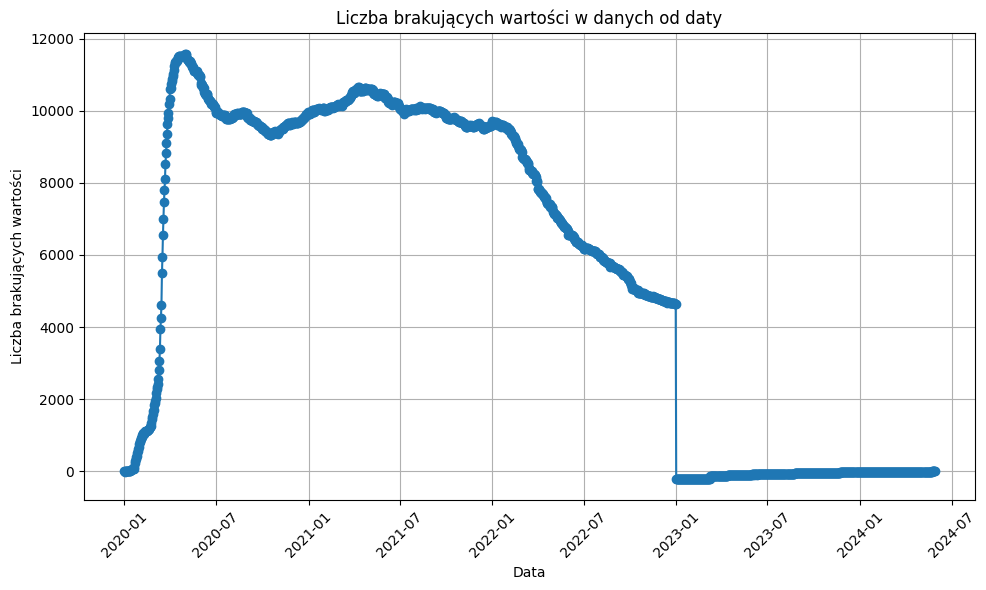

Diamond Princess 307
Colombia 655
Peru 677
Grand Princess 10
Costa Atlantica 81
Guernsey 695
Macao 692
Jersey 658
Pitcairn 441
Tokelau 533


In [ ]:
globe = dane.copy()
globe = globe.sort_values(by="date")
globe = globe.reset_index(drop=True)

end = globe[globe["date"] == "2023-01-01"].index[0]

print("Braki w kolumnie zakarzeń:")
print("Oficjalny koniec pandemii:2023-05-05 ")
print("Wszystkie dane: {:.2f}%".format(globe["confirmed"].isnull().mean()*100))
print("Przed 5.05.2023: {:.2f}%".format(globe["confirmed"][:end].isnull().mean()*100))
print("Po 5.05.2023: {:.2f}%\n".format(globe["confirmed"][end:].isnull().mean()*100))

a = globe.copy()
a = a.sort_values('date')
a = a.reset_index(drop=True)
#a['government_response_index'].unique()
#len(a['government_response_index'].unique())
a['government_response_index'] = a['government_response_index'].fillna(-1)
b = a[['date','government_response_index']]
b = b.groupby("date").sum()
plt.figure(figsize=(10, 6))
plt.plot(b['government_response_index'], marker='o', linestyle='-')
plt.title('Liczba brakujących wartości w danych od daty')
plt.xlabel('Data')
plt.ylabel('Liczba brakujących wartości')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

end = globe[globe["date"] == "2023-01-01"].index[0]
globe = globe.iloc[:end]

d = (globe.iloc[-1,0] - globe.iloc[0,0]).days

country_out = []
for i in globe["administrative_area_level_1"].unique():
    a = globe[globe["administrative_area_level_1"] == i]
    if len(a)*1.5<d:
        country_out.append(i)
        print(i,len(a))

globe = globe[~globe["administrative_area_level_1"].isin(country_out)]

Zastepujemy ujemne wartości dodatnimi.

Sprawdzamy ilość ujemnych wartości w danych.

In [ ]:
g = globe.copy()

g.loc[:, g.columns] = g.loc[:, g.columns].applymap(lambda x: abs(x) if isinstance(x, (int, float)) and x < 0 else x)

g1 = g.iloc[:,0:-3]

for i in g1.columns:
    if i != 'date':
        uj = (g1[i] < 0).sum()
        print(i,uj)

confirmed 0
deaths 0
school_closing 0
workplace_closing 0
cancel_events 0
gatherings_restrictions 0
transport_closing 0
stay_home_restrictions 0
internal_movement_restrictions 0
international_movement_restrictions 0
information_campaigns 0
testing_policy 0
contact_tracing 0
facial_coverings 0
vaccination_policy 0
elderly_people_protection 0
government_response_index 0
stringency_index 0
containment_health_index 0
economic_support_index 0


Dane kumulatywne sumujemy uzupełniamy braki w danych.

Dla reszty danych podczas grupowania liczymy srednia.

Łączymy zbiory po zmiennej date

Robimy odzielny zbior z populacją

In [ ]:
gl = g.copy()

g_pop = gl.iloc[:,-3:]
g_cum = gl.iloc[:,0:3]
g_res = gl.iloc[:, [0] + list(range(3, len(g.columns) - 3))]
g_pop = g_pop.groupby("administrative_area_level_1").max()

g_cum = g_cum.groupby("date").sum()

for i in g_cum.columns:
    for j in range(len(g_cum[i])-1):
        if g_cum[i][j] >  g_cum[i][j+1]:
            g_cum[i][j+1] = g_cum[i][j]

g_res = g_res.groupby("date").mean()

merged_df = pd.merge(g_cum, g_res, on='date')
merged_df

,confirmed,deaths,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index
date,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,1.040000,0.000000,1.190000,0.000000
2020-01-02,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.780000,0.000000,0.892500,0.000000
2020-01-03,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.008000,0.008000,0.040000,0.008000,0.000000,0.016000,0.206160,0.044480,0.235680,0.000000
2020-01-04,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.007937,0.031746,0.039683,0.007937,0.000000,0.015873,0.254127,0.044127,0.290476,0.000000
2020-01-05,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.020134,0.026846,0.040268,0.006711,0.000000,0.013423,0.267315,0.093289,0.305503,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,680698651.0,6073129.0,0.245509,0.395210,0.377246,0.323353,0.11976,0.083832,0.143713,0.664671,1.640719,2.341317,0.598802,1.658683,4.946108,0.443114,27.906766,17.778323,30.150299,12.200599
2022-12-28,685698110.0,6073129.0,0.245509,0.395210,0.377246,0.323353,0.11976,0.083832,0.143713,0.670659,1.640719,2.341317,0.598802,1.658683,4.946108,0.443114,27.916108,17.794970,30.160958,12.200599
2022-12-29,689812465.0,6073129.0,0.233533,0.383234,0.371257,0.305389,0.11976,0.083832,0.143713,0.652695,1.640719,2.341317,0.598802,1.658683,4.946108,0.443114,27.791377,17.573174,30.018383,12.200599


Usunięcie zmiennych z najniższą korelacją: information_campaigns i facial_coverings.

Nie udało sie przewidziec zakażeń ani śmiertelności poprzez dzienne zmiany: 'confirmed_daily', 'deaths_daily'.

Z pierwszej grupy (zmienne o bardzo wysokiej korelacji między sobą) wybieramy trzy zmienne o najniższej korelacji między sobą i największej korelacji z zmiennymi objaśnianymi: gatherings_restrictions, stay_home_restrictions, international_movement_restrictions.

Z drugiej grupy (zmienne o bardzo wysokiej korelacji między sobą) wybieramy dwie zmienne o najniższej korelacji między sobą i największej korelacji z zmiennymi objaśnianymi: stringency_index, economic_support_index.


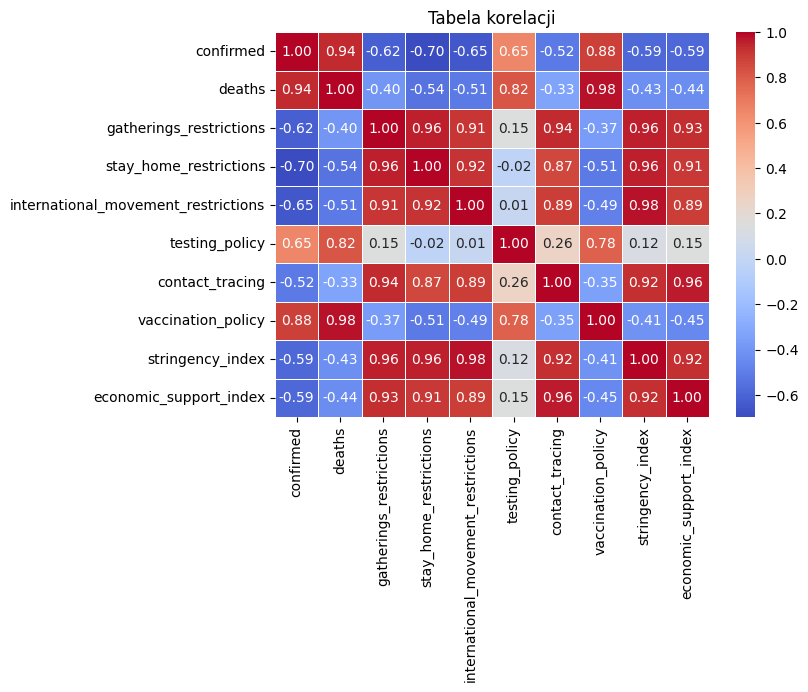

In [ ]:
all = merged_df.copy()
all = all.drop(["information_campaigns","facial_coverings"],axis=1)
all = all.drop(['elderly_people_protection','government_response_index','containment_health_index'],axis=1)
all = all.drop(['school_closing', 'workplace_closing', 'cancel_events','transport_closing','internal_movement_restrictions',],axis=1)

correlation_matrix = all.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Tabela korelacji')
plt.show()

Wykonujemy regresję liniową od każdej zmiennej dla obu zmienny objaśnianych najlepsze dopasowanie  ma zmienna vaccination_policy

In [ ]:
xz = all.iloc[:, 2:]
yz = all.iloc[:, :2]

wyniki = []

for feature in yz.columns:
    y = yz[feature]
    for col in xz.columns:
        X = xz[[col]]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        wyniki.append({
            'objasniajaca': col,
            'objasniana': feature,
            'mse': mse,
            'mae': mae,
            'r2': r2
        })
        wyniki_df = pd.DataFrame(wyniki)


confirmed_results = wyniki_df[wyniki_df['objasniana'] == 'confirmed'].sort_values(by='r2', ascending=False)
deaths_results = wyniki_df[wyniki_df['objasniana'] == 'deaths'].sort_values(by='r2', ascending=False)

pd.options.display.float_format = '{:.2f}'.format

linear = pd.concat([confirmed_results,deaths_results])
linear.reset_index(drop=True)

,objasniajaca,objasniana,mse,mae,r2
0,vaccination_policy,confirmed,10516096897410950.00,80512070.16,0.78
1,testing_policy,confirmed,27395638280713416.00,150392181.31,0.43
2,stay_home_restrictions,confirmed,27777837162650652.00,119099644.68,0.43
3,international_movement_restrictions,confirmed,28812911230459840.00,123176949.37,0.40
4,gatherings_restrictions,confirmed,32458086062834956.00,136037735.50,0.33
5,stringency_index,confirmed,34219653391678596.00,134496956.77,0.29
6,economic_support_index,confirmed,35502029493114172.00,127951653.45,0.27
7,contact_tracing,confirmed,36542699767533888.00,143707400.91,0.24
8,vaccination_policy,deaths,222236977436.95,429627.42,0.96
9,testing_policy,deaths,1667829543564.81,1144052.15,0.68


Liniowość:
Reszty są losowo rozrzucone, model nie jest wystarczający do określenia tej zależności.

Heteroskedastyczność:
Reszty nie są rozłożone równomiernie, występuje zmienna wariancja reszt.

Wynika z tego że nie są spełnione założenia dla regresji liniowej

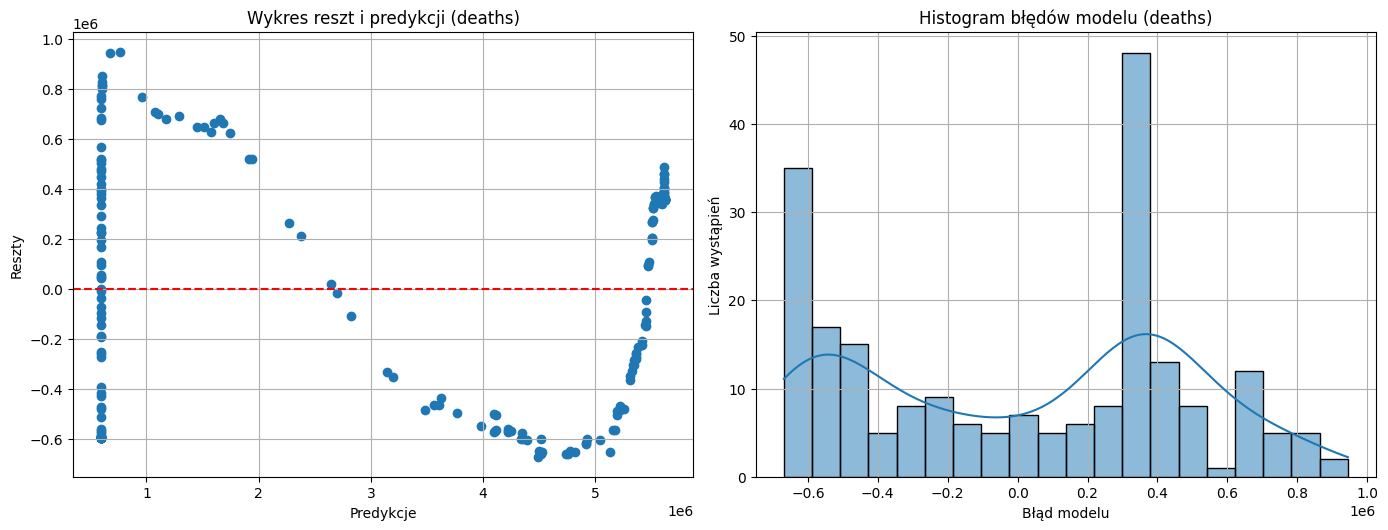

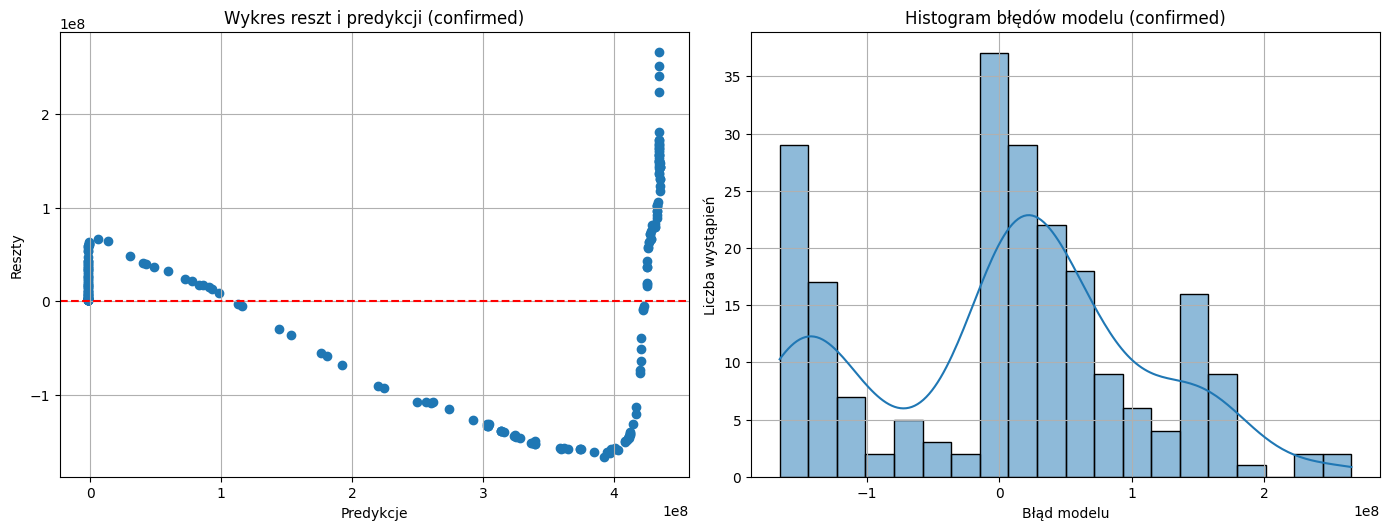

In [ ]:
columns = ["deaths", "confirmed"]

for col in columns:
    X = all[["vaccination_policy"]]
    y = all[col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_test)
    residuals = y_test - predicted_values

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(predicted_values, residuals)
    plt.xlabel('Predykcje')
    plt.ylabel('Reszty')
    plt.title(f'Wykres reszt i predykcji ({col})')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=20, kde=True)
    plt.xlabel('Błąd modelu')
    plt.ylabel('Liczba wystąpień')
    plt.title(f'Histogram błędów modelu ({col})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Wybieramy zmienne dla regresji wielowymiarowej.



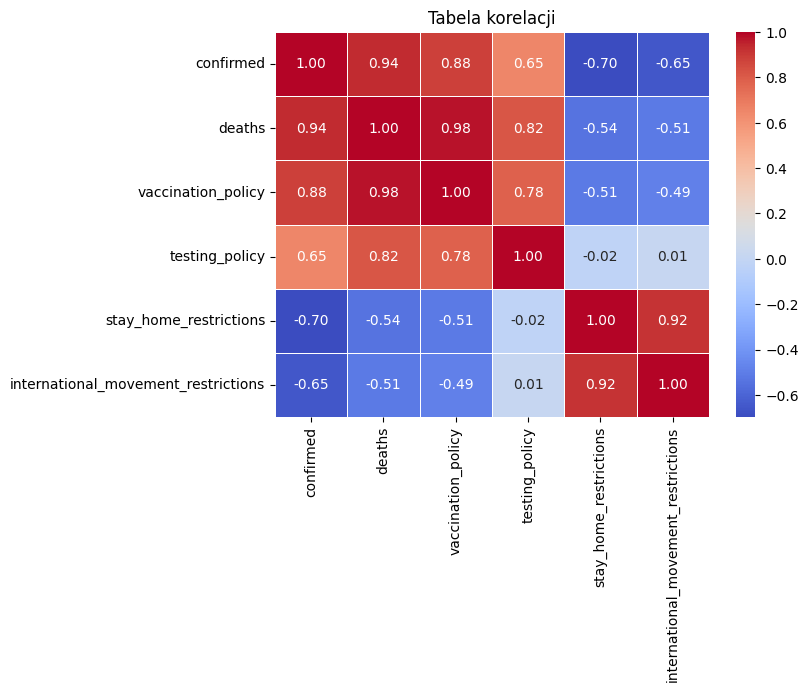

In [ ]:
best_columns = linear.iloc[:4, 0].values
selected_columns = ['confirmed','deaths'] + list(best_columns)
sel = all[selected_columns]
correlation_matrix = sel.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Tabela korelacji')
plt.show()


Wszystkie metryki pokazują że regresja wieloraka jest lepsza.

In [ ]:
X = sel.iloc[:,2:]
y = sel.iloc[:,:2]

wyniki = []
for feature in yz.columns:
    y = yz[feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    wyniki.append({
        'objasniajaca': X.columns.tolist(),
        'objasniana': feature,
        'mse': mse,
        'mae': mae,
        'r2': r2
    })
    wyniki_df = pd.DataFrame(wyniki)

wyniki_df = pd.concat([deaths_results.head(1),wyniki_df])
wyniki_df = pd.concat([confirmed_results.head(1),wyniki_df],ignore_index=True)
wyniki_df

,objasniajaca,objasniana,mse,mae,r2
0,vaccination_policy,confirmed,10516096897410950.00,80512070.16,0.78
1,vaccination_policy,deaths,222236977436.95,429627.42,0.96
2,"[vaccination_policy, testing_policy, stay_home...",confirmed,4729118434307882.00,55486831.34,0.90
3,"[vaccination_policy, testing_policy, stay_home...",deaths,60892964486.79,203505.34,0.99


Predykcja wielomianowa dla zmiennych "confirmed" i "deaths".

In [ ]:
X = sel.iloc[:,2:]
y = sel.iloc[:,:2]

wyniki =[]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

wyniki.append({
    'objasniajaca': X.columns.tolist(),
    'mse': mse,
    'mae': mae,
    'r2': r2
})
wyniki_df = pd.DataFrame(wyniki)

wyniki_df

,objasniajaca,mse,mae,r2
0,"[vaccination_policy, testing_policy, stay_home...",2364589663636185.50,27845168.34,0.95


Wyniki dla zmiennej "confirmed":

SVR:

Wysoki błąd kwadratowy i niski współczynnik determinacji sugerują, że model SVR nie jest odpowiedni dla tych danych lub potrzebuje dalszej optymalizacji.
Drzewo decyzyjne:

Niski błąd kwadratowy i wysoki współczynnik determinacji wskazują na bardzo dobrą dopasowanie modelu drzewa decyzyjnego do danych.

Las losowy:

Podobnie jak w przypadku drzewa decyzyjnego, niski błąd kwadratowy i wysoki współczynnik determinacji sugerują, że model lasu losowego dobrze dopasowuje się do danych.

Wyniki dla zmiennej "deaths":

SVR :

Podobnie jak dla zmiennej "confirmed", wysoki błąd kwadratowy i niski współczynnik determinacji sugerują, że model SVR nie jest odpowiedni dla tych danych.

Drzewo decyzyjne:

Bardzo niski błąd kwadratowy i wysoki współczynnik determinacji wskazują na doskonałe dopasowanie modelu drzewa decyzyjnego do danych.

Las losowy :

Podobnie jak dla zmiennej "deaths", niski błąd kwadratowy i wysoki współczynnik determinacji sugerują, że model lasu losowego dobrze dopasowuje się do danych.

In [ ]:
X_selected = all[sel.columns[2:]]
columns = ["confirmed", "deaths"]

for col in columns:
    y_selected = all[col]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

    print(f"\nResults for {col}:\n")

    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    print(f"SVR - Mean Squared Error: {mse_svr}")
    print(f"SVR - R-squared Score: {r2_svr}")

    tree_model = DecisionTreeRegressor()
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    mse_tree = mean_squared_error(y_test, y_pred_tree)
    r2_tree = r2_score(y_test, y_pred_tree)
    print(f"Decision Tree - Mean Squared Error: {mse_tree}")
    print(f"Decision Tree - R-squared Score: {r2_tree}")

    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"Random Forest - Mean Squared Error: {mse_rf}")
    print(f"Random Forest - R-squared Score: {r2_rf}")


Results for confirmed:

SVR - Mean Squared Error: 5.168432438841212e+16
SVR - R-squared Score: -0.06856355051786123
Decision Tree - Mean Squared Error: 7486239528016.173
Decision Tree - R-squared Score: 0.9998452234253858
Random Forest - Mean Squared Error: 10210819924029.377
Random Forest - R-squared Score: 0.9997888932452764

Results for deaths:

SVR - Mean Squared Error: 5364002900127.023
SVR - R-squared Score: -0.035204840778040314
Decision Tree - Mean Squared Error: 284664833.1020048
Decision Tree - R-squared Score: 0.9999450622196309
Random Forest - Mean Squared Error: 165097141.02939546
Random Forest - R-squared Score: 0.9999681377205094


Wybieramy kraj z najmniejszą ilością brakujących danych.
Jest to Austria.

In [ ]:
one = g.copy()
one = one.sort_values("administrative_area_level_1")
missing = one.groupby('administrative_area_level_1').apply(lambda x: x.isnull().sum())

country_with_most_missing_values = missing.sum(axis=1).idxmin()
most_missing_values = missing.sum(axis=1).min()

print("Kraj z największą liczbą brakujących wartości:", country_with_most_missing_values)
print("Liczba brakujących wartości:", most_missing_values)
one = one[one["administrative_area_level_1"] == "Austria"]
one = one.sort_values("date").reset_index(drop=True)
one

Kraj z największą liczbą brakujących wartości: Austria
Liczba brakujących wartości: 0


,date,confirmed,deaths,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,...,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index,administrative_area_level_1,population,iso_alpha_3
0,2020-02-26,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,11.46,11.11,13.10,0.00,Austria,8840521.00,AUT
1,2020-02-27,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,11.46,11.11,13.10,0.00,Austria,8840521.00,AUT
2,2020-02-28,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,11.46,11.11,13.10,0.00,Austria,8840521.00,AUT
3,2020-02-29,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,11.46,11.11,13.10,0.00,Austria,8840521.00,AUT
4,2020-03-01,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,11.46,11.11,13.10,0.00,Austria,8840521.00,AUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,2022-12-27,5691709.00,21559.00,2.00,2.00,1.00,2.00,0.00,0.00,0.00,...,2.00,5.00,3.00,60.42,35.19,54.76,100.00,Austria,8840521.00,AUT
1036,2022-12-28,5696559.00,21566.00,2.00,2.00,1.00,2.00,0.00,0.00,0.00,...,2.00,5.00,3.00,60.42,35.19,54.76,100.00,Austria,8840521.00,AUT
1037,2022-12-29,5700848.00,21579.00,2.00,2.00,1.00,2.00,0.00,0.00,0.00,...,2.00,5.00,3.00,60.42,35.19,54.76,100.00,Austria,8840521.00,AUT
1038,2022-12-30,5705075.00,21589.00,2.00,2.00,1.00,2.00,0.00,0.00,0.00,...,2.00,5.00,3.00,60.42,35.19,54.76,100.00,Austria,8840521.00,AUT


Usuwamy inne zmienne niz ilościowe i zmienną information_campaigns która ma jedną wartość.

Wybieramy najlepiej dopasowane zmienne eliminując wysokie korelacje między zmiennymi.

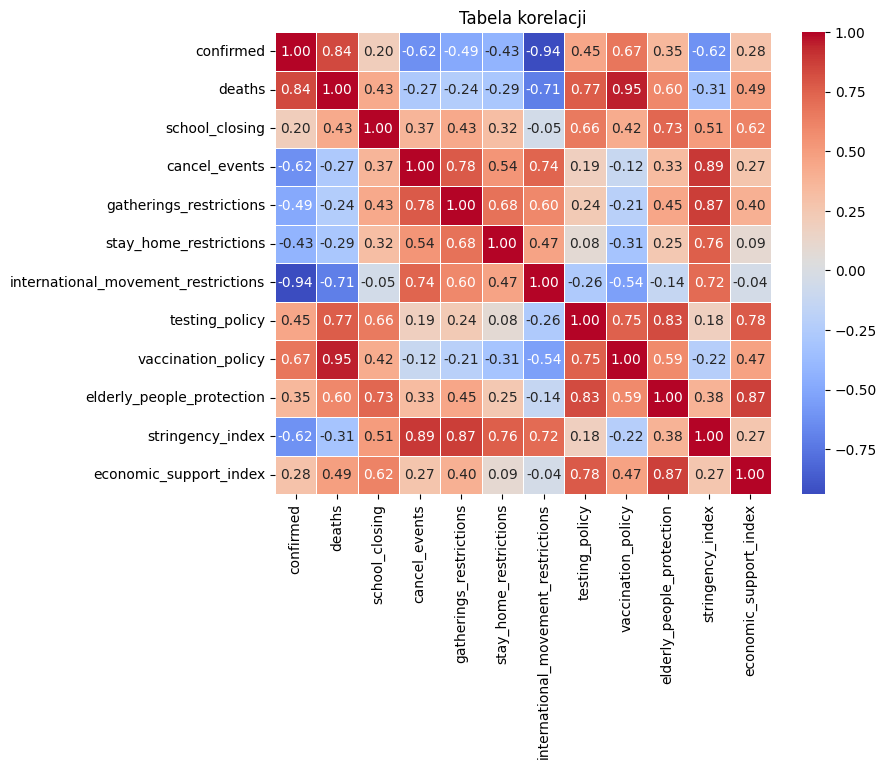

Liczba etykiet zmiennej confirmed 1040
Liczba etykiet zmiennej deaths 993
Liczba etykiet zmiennej school_closing 4
Liczba etykiet zmiennej cancel_events 3
Liczba etykiet zmiennej gatherings_restrictions 4
Liczba etykiet zmiennej stay_home_restrictions 3
Liczba etykiet zmiennej international_movement_restrictions 4
Liczba etykiet zmiennej testing_policy 3
Liczba etykiet zmiennej vaccination_policy 5
Liczba etykiet zmiennej elderly_people_protection 3
Liczba etykiet zmiennej stringency_index 40
Liczba etykiet zmiennej economic_support_index 4


In [ ]:
Aus = one.copy()
Aus_iden = Aus.loc[0,["administrative_area_level_1","population","iso_alpha_3"]]
Aus = Aus.drop(["information_campaigns","population","administrative_area_level_1","iso_alpha_3"],axis=1)
Aus = Aus.drop(['government_response_index','containment_health_index'],axis=1)
Aus = Aus.drop(["contact_tracing","facial_coverings",'workplace_closing','transport_closing','internal_movement_restrictions',],axis=1)
Aus.set_index('date', inplace=True)

correlation_matrix = Aus.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Tabela korelacji')
plt.show()
for i in Aus.columns:
  print('Liczba etykiet zmiennej '+ i + ' {}'.format(len(Aus.loc[:,i].unique())))

Wykonujemy regresję liniową od każdej zmiennej dla obu zmienny objaśnianych najlepsze dopasowanie dla zmiennej:

confirmed ma zmienna international_movement_restrictions

deaths ma zmienna vaccination_policy

In [ ]:
zmienne = Aus.copy()

pakiety_zmiennych = []
xz = zmienne.iloc[:, 2:]
yz = zmienne.iloc[:, :2]

wyniki = []

for feature in yz.columns:
    y = yz[feature]
    for col in xz.columns:
        X = xz[[col]]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        wyniki.append({
            'objasniajaca': col,
            'objasniana': feature,
            'mse': mse,
            'mae': mae,
            'r2': r2
        })
        wyniki_df = pd.DataFrame(wyniki)


confirmed_results = wyniki_df[wyniki_df['objasniana'] == 'confirmed'].sort_values(by='r2', ascending=False)
deaths_results = wyniki_df[wyniki_df['objasniana'] == 'deaths'].sort_values(by='r2', ascending=False)

linear = pd.concat([confirmed_results,deaths_results])

linear.reset_index(drop=True)

,objasniajaca,objasniana,mse,mae,r2
0,international_movement_restrictions,confirmed,544048413460.15,442437.29,0.87
1,vaccination_policy,confirmed,2176690781000.58,1215700.99,0.46
2,cancel_events,confirmed,2289353972279.49,1077815.28,0.43
3,stringency_index,confirmed,2346675784971.89,1176944.66,0.42
4,gatherings_restrictions,confirmed,2866066675418.37,1379107.55,0.29
5,testing_policy,confirmed,3194336125015.35,1543638.28,0.21
6,stay_home_restrictions,confirmed,3202502811568.95,1471710.98,0.21
7,elderly_people_protection,confirmed,3580221001764.24,1685855.15,0.11
8,economic_support_index,confirmed,3707407056369.09,1735412.55,0.08
9,school_closing,confirmed,3987659826017.90,1761593.59,0.01


Rozkład reszt pokazuje pewną nieliniową zależność.

Widoczne są skupiska puntów, świadczy to o zmiennej wariancji.

Wniosek: nie są spełnione założenia regresji liniowej.

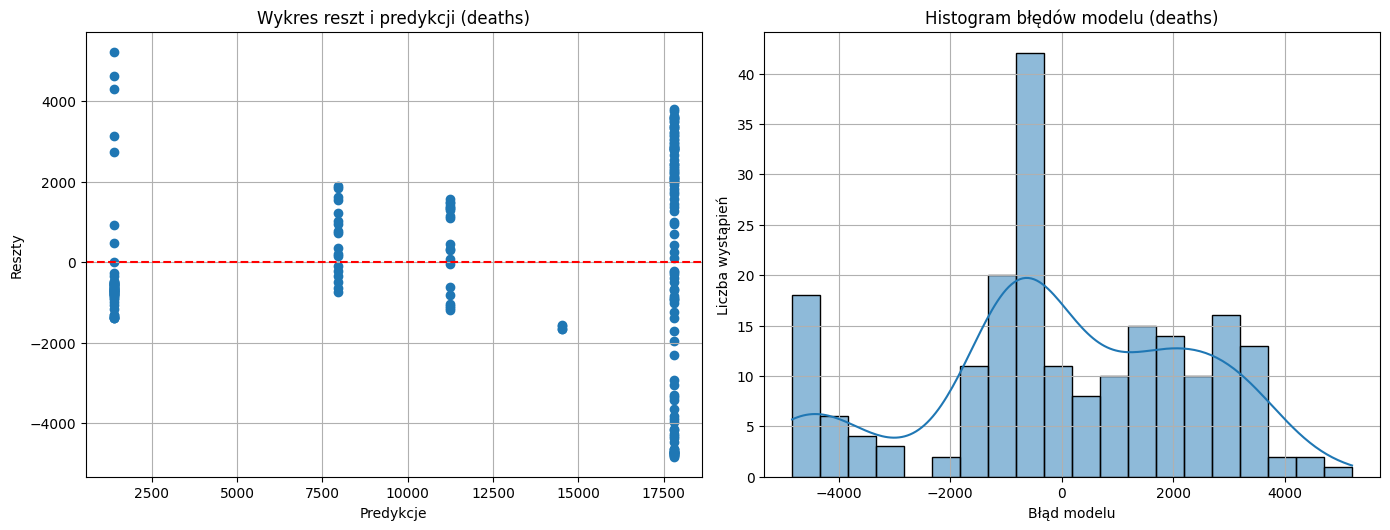

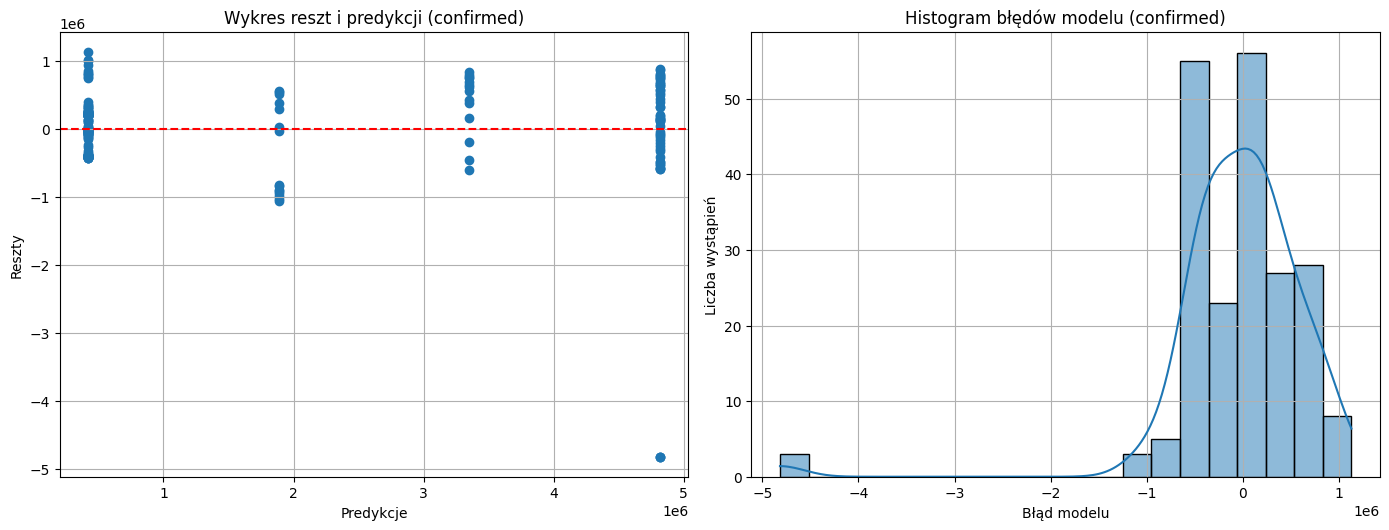

In [ ]:
columns = ["deaths", "confirmed"]

for col in columns:
    if col == 'confirmed':
        X = zmienne[["international_movement_restrictions"]]
    else:
        X = zmienne[["vaccination_policy"]]
    y = zmienne[col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_test)
    residuals = y_test - predicted_values

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(predicted_values, residuals)
    plt.xlabel('Predykcje')
    plt.ylabel('Reszty')
    plt.title(f'Wykres reszt i predykcji ({col})')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=20, kde=True)
    plt.xlabel('Błąd modelu')
    plt.ylabel('Liczba wystąpień')
    plt.title(f'Histogram błędów modelu ({col})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Wybieramy zmienne dla regresji wielowymiarowej.


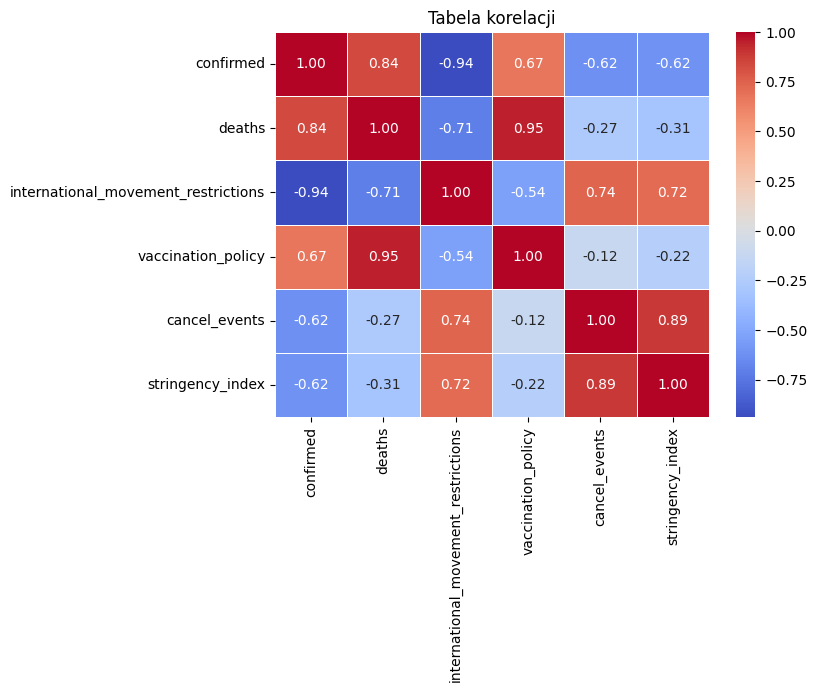

In [ ]:
sel = one.copy()

best_columns = linear.iloc[:4, 0].values
selected_columns = ['confirmed','deaths'] + list(best_columns)
sel = zmienne[selected_columns]

correlation_matrix = sel.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Tabela korelacji')
plt.show()


Wszystkie metryki pokazują że regresja wieloraka lepiej przewiduje zmienną objaśnianą.

In [ ]:
XX = sel.iloc[:,2:]
yy = sel.iloc[:,:2]

wyniki = []
for feature in yy.columns:
    y = yy[feature]

    X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    wyniki.append({
        'objasniajaca': XX.columns.tolist(),
        'objasniana': feature,
        'mse': mse,
        'mae': mae,
        'r2': r2
    })
    wyniki_df = pd.DataFrame(wyniki)

wyniki_df = pd.concat([deaths_results.head(1),wyniki_df])
wyniki_df = pd.concat([confirmed_results.head(1),wyniki_df],ignore_index=True)
wyniki_df

,objasniajaca,objasniana,mse,mae,r2
0,international_movement_restrictions,confirmed,544048413460.15,442437.29,0.87
1,vaccination_policy,deaths,5738320.38,1925.85,0.90
2,"[international_movement_restrictions, vaccinat...",confirmed,363083047932.74,347634.49,0.91
3,"[international_movement_restrictions, vaccinat...",deaths,2245776.06,1094.90,0.96


Predykcja wielomianowa dla zmiennych "confirmed" i "deaths".

In [ ]:
XX = sel.iloc[:,2:]
yy = sel.iloc[:,:2]


wyniki =[]
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

wyniki.append({
    'objasniajaca': X.columns.tolist(),
    'mse': mse,
    'mae': mae,
    'r2': r2
})
wyniki_df = pd.DataFrame(wyniki)

wyniki_df

,objasniajaca,mse,mae,r2
0,[international_movement_restrictions],181542646854.40,174364.69,0.94


Wyniki dla zmiennej "confirmed":

SVR:

Wysoki błąd kwadratowy i niski współczynnik determinacji sugerują, że model SVR nie jest odpowiedni dla tych danych lub potrzebuje dalszej optymalizacji.
Drzewo decyzyjne:

Niski błąd kwadratowy i wysoki współczynnik determinacji wskazują na bardzo dobrą dopasowanie modelu drzewa decyzyjnego do danych.

Las losowy:

Podobnie jak w przypadku drzewa decyzyjnego, niski błąd kwadratowy i wysoki współczynnik determinacji sugerują, że model lasu losowego dobrze dopasowuje się do danych.


Wyniki dla zmiennej "deaths":

SVR :

Podobnie jak dla zmiennej "confirmed", wysoki błąd kwadratowy i niski współczynnik determinacji sugerują, że model SVR nie jest odpowiedni dla tych danych.

Drzewo decyzyjne:

Bardzo niski błąd kwadratowy i wysoki współczynnik determinacji wskazują na doskonałe dopasowanie modelu drzewa decyzyjnego do danych.

Las losowy :

Podobnie jak dla zmiennej "deaths", niski błąd kwadratowy i wysoki współczynnik determinacji sugerują, że model lasu losowego dobrze dopasowuje się do danych.

In [ ]:
X_selected = sel[sel.columns[2:]]
columns = ["confirmed", "deaths"]

for col in columns:
    y_selected = sel[col]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

    print(f"\nResults for {col}:\n")

    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    print(f"SVR - Mean Squared Error: {mse_svr}")
    print(f"SVR - R-squared Score: {r2_svr}")

    tree_model = DecisionTreeRegressor()
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    mse_tree = mean_squared_error(y_test, y_pred_tree)
    r2_tree = r2_score(y_test, y_pred_tree)
    print(f"Decision Tree - Mean Squared Error: {mse_tree}")
    print(f"Decision Tree - R-squared Score: {r2_tree}")

    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"Random Forest - Mean Squared Error: {mse_rf}")
    print(f"Random Forest - R-squared Score: {r2_rf}")


Results for confirmed:

SVR - Mean Squared Error: 5284937680717.248
SVR - R-squared Score: -0.31129068683013683
Decision Tree - Mean Squared Error: 58952039509.61732
Decision Tree - R-squared Score: 0.9853729097581124
Random Forest - Mean Squared Error: 59070012218.09676
Random Forest - R-squared Score: 0.9853436385493914

Results for deaths:

SVR - Mean Squared Error: 57626279.3569331
SVR - R-squared Score: -0.017737842350896926
Decision Tree - Mean Squared Error: 189844.0704940006
Decision Tree - R-squared Score: 0.9966471634670193
Random Forest - Mean Squared Error: 191544.71871809766
Random Forest - R-squared Score: 0.9966171283151146
